LSTM、GRUを使った文書の自動作成。 宮沢賢治の『銀河鉄道の夜』を学習データに使い、乱歩風の文章を自動生成する。

In [1]:
#データの前処理

import re

with open("gingatetsudono_yoru.txt", mode="r", encoding="utf-8") as f:  # 『銀河鉄道の夜』ファイルの読み込み
    text_original = f.read()

text = re.sub("《[^》]+》", "", text_original) # ルビの削除
text = re.sub("［[^］]+］", "", text) # 読みの注意の削除
text = re.sub("[｜ 　]", "", text) # | と全角半角スペースの削除
print("文字数", len(text))  # len() で文字列の文字数も取得可能

文字数 38753


In [2]:
#LSTM、GRU共通の各設定

n_rnn = 10  # 時系列の数
batch_size = 128
epochs = 60
n_mid = 256  # 中間層のニューロン数

In [4]:
#文字のベクトル化

import numpy as np

# インデックスと文字で辞書を作成
chars = sorted(list(set(text)))  # setで文字の重複をなくし、各文字をリストに格納する
print("文字数（重複無し）", len(chars))
char_indices = {}  # 文字がキーでインデックスが値
for i, char in enumerate(chars):
    char_indices[char] = i
indices_char = {}  # インデックスがキーで文字が値
for i, char in enumerate(chars):
    indices_char[i] = char
 
# 時系列データと、それから予測すべき文字を取り出す
time_chars = []
next_chars = []
for i in range(0, len(text) - n_rnn):
    time_chars.append(text[i: i + n_rnn])
    next_chars.append(text[i + n_rnn])
 
# 入力と正解をone-hot表現で表す
x = np.zeros((len(time_chars), n_rnn, len(chars)), dtype=np.bool)
t = np.zeros((len(time_chars), len(chars)), dtype=np.bool)
for i, t_cs in enumerate(time_chars):
    t[i, char_indices[next_chars[i]]] = 1  # 正解をone-hot表現で表す
    for j, char in enumerate(t_cs):
        x[i, j, char_indices[char]] = 1  # 入力をone-hot表現で表す
        
print("xの形状", x.shape)
print("tの形状", t.shape)

文字数（重複無し） 1049
xの形状 (38743, 10, 1049)
tの形状 (38743, 1049)


In [5]:
#LSTMモデルの構築

from keras.models import Sequential
from keras.layers import Dense, LSTM

model_lstm = Sequential()
model_lstm.add(LSTM(n_mid, input_shape=(n_rnn, len(chars))))
model_lstm.add(Dense(len(chars), activation="softmax"))
model_lstm.compile(loss='categorical_crossentropy', optimizer="adam")
print(model_lstm.summary())

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               1337344   
_________________________________________________________________
dense_1 (Dense)              (None, 1049)              269593    
Total params: 1,606,937
Trainable params: 1,606,937
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
#文書生成用の関数の作成

from keras.callbacks import LambdaCallback
 
def on_epoch_end(epoch, logs):
    print("エポック: ", epoch)

    beta = 5  # 確率分布を調整する定数
    prev_text = text[0:n_rnn]  # 入力に使う文字
    created_text = prev_text  # 生成されるテキスト
    
    print("シード: ", created_text)

    for i in range(400):
        # 入力をone-hot表現に
        x_pred = np.zeros((1, n_rnn, len(chars)))
        for j, char in enumerate(prev_text):
            x_pred[0, j, char_indices[char]] = 1
        
        # 予測を行い、次の文字を得る
        y = model.predict(x_pred)
        p_power = y[0] ** beta  # 確率分布の調整
        next_index = np.random.choice(len(p_power), p=p_power/np.sum(p_power))        
        next_char = indices_char[next_index]

        created_text += next_char
        prev_text = prev_text[1:] + next_char

    print(created_text)
    print()

# エポック終了後に実行される関数を設定
epock_end_callback= LambdaCallback(on_epoch_end=on_epoch_end)

In [7]:
#学習

model = model_lstm
history_lstm = model_lstm.fit(x, t,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[epock_end_callback])

Epoch 1/60
38743/38743 [==============================] - 21s 532us/step - loss: 4.9459
エポック:  0
シード:  「ではみなさんは、そ
「ではみなさんは、そ。のいのたたらいいいいかいしたいしたいいのくたのたのたののいらし。いたしたないていのいい。いいのたのいののいんのしたたしたいたのいいした。いいいたのいたのたのたいのなのたのたいたしいののかたたのいいいの。いいいたの。たのまいいのしたした。のした。。いいたた。たたのならののいたいいいていったいたたのたいましたいたしたとからいたしたのものういたいいのたのいしたのいかたしたた。いたいい。ましたかたのいた。いた。の。い。たいいまいて、たいたいいなのの。いたいのいのいいいたのしたいたのかたたした。かいいいいたたいいしたたたかかいとのかい。いいいた。のてした。たい。の、たののしたいいいたいかがたた。のたいいいたいのたいた。いたのいした。たした。。ていなたんいたいていいないいのいういていのいののしたいのいんいいたたたのた。ののいいのいのいたのまいのた。ってたいもた。たいていいいでいのい。たのののでした。

Epoch 2/60
38743/38743 [==============================] - 20s 522us/step - loss: 4.5346
エポック:  1
シード:  「ではみなさんは、そ
「ではみなさんは、そのだにました。
「あのは、に、いました。
「はは、は、にした。
「ははいうした。
「あのんののののました。
「あのとのは、、いました。
「あのはいていた。
「あのもうのののっていた。
「ののははんした。」
「したのくのかのかかっていた。
「のは、いてした。
「あ、もうのもうの、した。
「うのは、のっていた。」
「、ははははした。
「あのはのうは、いていました。
「は、のとだの、のでした。
「ののあのだんいのました。
「のののは、の、このののました。
「あうのがいました。
「いうののののの、はいのんのののいのなのとのました。
「あののでした。
「のは、は、いの、るのうののののいました。
「んのあのののなりました。
「いあした。
「あの、はいした。
「うは、らのっていた。」
「あは、ものといって

38743/38743 [==============================] - 20s 516us/step - loss: 2.38910s - loss: 2.3
エポック:  16
シード:  「ではみなさんは、そ
「ではみなさんは、そうにはこんなになって、こっちに見えるというとうにならいました。
「ああ、」
「ああ、ぼくさんのお母さんのようになって、その人は、きれいないろの方へ行って、その人は、いるのですから、どこからはもうじゃないようになって、その人は、もうときの子になっていろいろになって、その人は、一つにしいついないたのです。
「ああ、こんなは、ころなから、どんなんでもなって、そのできまいですきのように、きっとりにもって来るのでした。
「ああ、このお母さんは、こんなに云いました。
「ああ、ぼくさんのころになって、どうからしているのでした。
「ああ、こんなは、こんなにはだんだんだんだんだんだ。」
「ああ、お母さんのお母さんのうちになって、その人は、こっちに見えると、その人は、白い岩の中に、一つかり白い巾をつっているので、その人は、もいながら云いました。
「ああ、」
「ああ、こんなんですか。」
「ああ、このぼんやりはど

Epoch 18/60
38743/38743 [==============================] - 22s 570us/step - loss: 2.2924
エポック:  17
シード:  「ではみなさんは、そ
「ではみなさんは、そうとうにながら、それからんなりました。
「ああ、その大きないです。」
「ああ、そうだ。」
「ああ、その大きないです。」
「ああ、お父さんは、あるようになって、どうか。」
「ああ、そうだ。」カムパネルラが、ましそうになって、その人は、どんですから、するところが、まるでは、きれいなでも、どんなんだんだ。」
「ああ、お父さんは、おっているよ。あるとこのはまたでは、わるとして、まっ黒なには、お父さんは、どうかっているのでした。
「ああ、そうな。」
「ああ、」
「ああ、さんなんなさい。」
「ああ、そうなんだ。ぼくは、こんなには、お父さんどこの中にはまるでです。」
「ああ、その大きなぼくは、白い大きな形を、あげませんなりました。
「ああ、その大きないのような気がしているように、すっきりのよう

38743/38743 [==============================] - 21s 540us/step - loss: 0.8608
エポック:  32
シード:  「ではみなさんは、そ
「ではみなさんは、そういう風にはだんだん早く見とまだ。どこから、いちから黒いいろが電燈がついつくて云いまがた。
「ぼくなり白く行ってよって行きのでい。」
「ええ、こっちを見あるんだんだろうか。」とうだろうと、こんでは一ぺんに乗っていに、まっすぐにかしてからわれました。
「そうだ。」ジョバンニは、お辞儀をして台所から出ました。
ジョバンニは、（ああたしい。ぼくはみんなはだんだんどこから、みんなはずうっところにくらくくしたような気がつました。
「あら、あった石です。ことおったろうと、こんでは、二人が、こと小にな黒い巾をつかったの前の、、一度にってあると、ザネリがやのないているなかに、どんどんどんどこら顔を出して見ているのでしい。こんなんですす。」ところが、こにつっているとここかが、もああるとはもしずからんだいろここへ行ってらんだんだんからんとだとだ。」
「ええ、」
「えなこの中は、どんどんどんだんだんだからなただ

Epoch 34/60
38743/38743 [==============================] - 21s 548us/step - loss: 0.7901
エポック:  33
シード:  「ではみなさんは、そ
「ではみなさんは、そういうとうに川だ、それからいうがら、そのからになくなり、そっかりました。
「それは、水の速さをを見るせよ。そのとき一時間になたのとを考え、そうだ、そこまっ中に、黒いぐやぐらさしたのをひろうしてそしてしていました。
「こんなりも、もこんでんかけていで、今日はかぺんなりか。」
「あなおがねえ。」ジョバンニは胸いっぱいにないつに浮せや橙やぐらいくさんがいました。その譜きもい旗にたった。
けれたいたいは、少しかかっかなんです。」
「いいないにもうするのでした。それからもうなったのです。。」
「いうごかも、どっからいいろいろの方へ走って行きました。けていきその中にはましょざめました。
「さいはいうご。ある、その中にはまた稜度の上に、白い時の光をあり、いの人は、まるで花の花の河原の円か、いろのからだった野原になって、こ

38743/38743 [==============================] - 22s 577us/step - loss: 0.1730
エポック:  48
シード:  「ではみなさんは、そ
「ではみなさんは、そういうふうに川だと云われたり、乳の流れたあとだと云われたりしていたこのあすこの水が、うんんとの窓からきのうと思わかね。」
「いえええないまです。」カムパネルラが、その紙きれが聞えためと云いました。ジョバンニは、すにか頭を引って、もさんの灯をことながこんでなっとそれに一緒にうかっているの。」
「ああぼくったらい。」カムパネルラが、その紙きれがすよっかしたがてうっしゃあのました。それは誰といたようにびきとうと、まった。光るごともうす。その白い怒なはぼちの方るように小さな銀貨の三角標がなだからだ。っかにひとしい。いこしでもわ。」
「ああすきだわ。」
「いいかけもわくした。いだかったのです。」
「いっとお菓子をつく、きばめてぼくしは窓のら見からくなって来たらか」
「それですか。」
「さあ、そう。」鳥捕りは、まし別の方で見え。」
「、やって、虫と、とうじろいろあわしくほの男のだ。あす、近くのからから

Epoch 50/60
38743/38743 [==============================] - 21s 547us/step - loss: 0.1595
エポック:  49
シード:  「ではみなさんは、そ
「ではみなさんは、そういうふうに川だと云われたり、乳の流れたあとだと云われたりしていたこのぼんやりと白いものがほんとうは何かご承知ですか。」先生は、黒板に吊した大きな黒い星座の図の、上から下へ白くけぶった銀河帯のようなところを指しながら、みんなに問をかけました。
カムパネルラは、その紙切れが何だったか待ち兼ねたというように急いでのぞきこみました。ジョバンニもうちょった窓のにとりもしようかならみちはこの集ったるみな声青じぎがんでしからか、どいてそのからはぼんやりしたらいいまった。ザネリがカムパネルかまった。あすことりがきだんだんそこに居えているのがあばたりともうつつましてどうかとまり鳥がなたまた。けれども見て、少しも誰ももなたれなないいい。」すすかがあるるました。その水子は黄いろの星高いなっかかを見えるよした両手を顔いろが、何べ

In [8]:
#GRUモデルの構築

from keras.layers import GRU

model_gru = Sequential()
model_gru.add(GRU(n_mid, input_shape=(n_rnn, len(chars))))
model_gru.add(Dense(len(chars), activation="softmax"))
model_gru.compile(loss='categorical_crossentropy', optimizer="adam")
print(model_gru.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 256)               1003008   
_________________________________________________________________
dense_2 (Dense)              (None, 1049)              269593    
Total params: 1,272,601
Trainable params: 1,272,601
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
#学習

model = model_gru
history_gru = model_gru.fit(x, t,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[epock_end_callback])

Epoch 1/60
38743/38743 [==============================] - 21s 540us/step - loss: 4.8995
エポック:  0
シード:  「ではみなさんは、そ
「ではみなさんは、そのには、のってのました。
「のンニはは、のののうのうののには、がっていました。
「のののはは、なのののって、っていた。
「のののは、にはってかるました。
「ののはははの、とのの、るのののってのました。
「ののンニはていました。
「ののンニははとしていました。
「のンニはははなのいました。
「のはのはなのてました。
「ののはははていがのってした。
「ののにはののんにのってました。
「のののははのにはってました。
「はのはは、のののはのにになました。
「のののはのなが、てました。
「うのはのはの、ののにのかっていてまたた。
「うののはははのっていてました。
「のののにはっていました。
「のののははののののにのにののさってのした。
「のののははいてていました。
「のンははがのました。
「のンニはの、のののののののはのて、ていた。ののはののののっていました。
「ののはは、うのののにのってした。
「

Epoch 2/60
38743/38743 [==============================] - 20s 514us/step - loss: 4.0254
エポック:  1
シード:  「ではみなさんは、そ
「ではみなさんは、そのです。」
「ああ、そうに、いました。
「あああいました。
「あああいました。
「ああ、あんだんない。」
「ああ、そのです。」
「あああいました。
「ああいた。
「あああいました。
「あああいました。
「あああんとう。」
「ああ、そうにあっているのです。」
「あっていました。
「あああた。
「あから、いのです。」
「ああ、そのです。
「あのです。」
「ああ、そのです。
「あっていました。
「あのです。
「ああ、そのです。」
「あああるとうに、うのです。」
「ああ、そのでした。
「あっているのです。」
「ああいました。
「ああ、そのです。」
「ああ、そうに、いました。
「ああ、そのです。」
「ああ、そのです。」
「あああいました。
「ああ、いうないました。
「ああ、そのです。」
「ああ、うこの

38743/38743 [==============================] - 20s 507us/step - loss: 1.0183
エポック:  16
シード:  「ではみなさんは、そ
「ではみなさんは、その人は小さな林に立っていました。
「あの人は、もうこんなものあかりだような音がするの崖とのうこになったのです。」ジョバンニは、少し大学んにさあままたら、いつなもものたちに見えるくるでさっきのようにうしくしくすがとうないてしましたられたあの人は、ちょうど青じめて、一つけていっているのを見ました。それはもうじきちかったのです。
「ああ、ここで降りなけぁ。」
そのはいうようにさっきの計算台のとは仕方ないった川のなこに居るんだ。」
「だけていたわ。」
「あんなにほんとうにこらえ兼ねた。いまがってくる。）と云いいとのですす。」青年はつつましく両手を組みました。
「ああ、それは、あの鳥捕りは、もうどんですからからないよ。」
「ああ、ここへ行って、それもらいらからたのです。ジョバンニは、どんどん中んはもうじっていらのいたのです。
「あれたくさんはねありがせんでしょう。」カムパネルラが、そのひとのように見

Epoch 18/60
38743/38743 [==============================] - 20s 519us/step - loss: 0.8806
エポック:  17
シード:  「ではみなさんは、そ
「ではみなさんは、そのからならだったのです。まるできたように見え、まっ黒なにつめて、浮彫のようにならんでいたのです。
「いまだね、この上は、黒いバンニも胸にああたせわしいうのうだ。）ジョバンニはまっ黒な頁いっぱいに白い点々のあっきかすかっと向うへからっのようにものききとうのうだろがねえると、その人の一つの上にも置いよかとしまうと、急きですっきのすすき、風にひるが植えられるもうでいた。」
「あああたしはね、ここへ行きます。そのまれは、こら砂の上って来るのです。それにもじもんですからこの下にはいるとこに行ったよ。僕もうごかなくないました。ジョバンニは俄かにその子供が見ていると思いてしていました。
「ああ、そうだ、今夜ケンタウル祭だねえ。」
「ああ、ここらではすぐれてね。」
「ああ、ここらではねえ。」
「あなかがたっていまわたしたち

38743/38743 [==============================] - 22s 555us/step - loss: 0.1348
エポック:  32
シード:  「ではみなさんは、そ
「ではみなさんは、そういうふうに川だと云われたり、乳の流れたあとだと云われたりしていたこのぼんやりと白いものがほんとうは何かご承知ですか。」先生は、黒板に吊した大きな黒い星座の図の、上から下へ白くけぶった銀河帯のようなところを指しながら、みんなに問をかけました。
カムパネルラは、その紙切れが何だったか待ち兼ねたというように急いでのぞきこみました。ジョバンニもうつれていました。
「おや、こっつかすす、おすかな波も、いちいんどにちてって見るけでした。
それとこってものほきのうしろの、ところと青じりや、うつか大人くちを見ているのでした。
「ああ、遠くからですね。」鳥捕りは、わかったというように雑作なくうなずきました。

九、ジョバンニの切符

「もうここらは白鳥区のおしまいです。ごらんなさい。あれが名高いアルビレオの観測所です。」
窓の外の、まるで花火でいっぱいのような、さまの川のまぎ水の、ぼくには一緒に乗えずかな

Epoch 34/60
38743/38743 [==============================] - 22s 558us/step - loss: 0.1147
エポック:  33
シード:  「ではみなさんは、そ
「ではみなさんは、そういうふうに川だと云われたり、乳の流れたあとだと云われたりしていたこのぼんやにと白なもやのその中はちょうどねえるの上に、わっしりもめいきれその方にこまった電し。ジョバンニは俄かに何とも云えずかなしい気がして思わず
「カムパネルラ、ここからはねおりて遊んで行こうよ。」とこわい顔をして云おうとしたくらいでした。
川は二つにわかれました。そのまっくらな島のまん中に高い高いやぐらが一つ組まれてその上に一人の寛い服を着て赤い帽子をかぶった男が立っていました。そして両手に赤と青の旗をもってそらを見上げて信号しているのでした。ジョバンニが見ている間その人はしきりに赤い旗をふっていましたが俄かに赤旗をおろしてうしろにかくすようにし青い旗を高く高くあげてまるでオーケストラの指揮者のように烈しく振りました。すると空中にはあすり

38743/38743 [==============================] - 25s 638us/step - loss: 0.0602
エポック:  48
シード:  「ではみなさんは、そ
「ではみなさんは、そういうふうに川だと云われたり、乳の流れたあとだと云われたりしていたこのぼんやりと白いものがほんとうは何かご承知ですか。」先生は、黒板に吊した大きな黒い星座の図の、上から下へ白くけぶった銀河帯のようなところを指しながら、みんなに問をかけました。
カムパネルラは、その雑誌を読むと、すぐお父さんの書斎から巨きな本をもってきて、ぎんがというところをひろげ、まっ黒な頁いっぱいに白い点々のある美しい写真を二人でいつまでも見たのでした。それをカムパネルラが忘れる筈もなかったのに、すぐに返事をしなかったのは、このごろぼくが、朝にも午后にも仕事がつらく、学校に出てももうみんなともはきはき遊ばず、カムパネルラともあんまり物を云わないようになったので、カムパネルラも、つい顔を赤くして笑いだしてしまいました。ところがその人は別に怒ったでもなく、頬をぴくぴくしながら返事しました。
「わっしはすぐそこで降ります。わっ

Epoch 50/60
38743/38743 [==============================] - 25s 646us/step - loss: 0.0535
エポック:  49
シード:  「ではみなさんは、そ
「ではみなさんは、そういうふうに川だと云われたり、乳の流れたあとだと云われたりしていたこのぼんやりと白いものがほんとうは何かご承知ですか。」先生は、黒板に吊した大きな黒い星座の図の、上から下へ白くけぶった銀河帯のようなところを指しながら、みんなに問をかけました。
カムパネルラが手をあげました。それから四五人手をあげました。ジョバンニもうごろでそしたという風で、われいでもぼくの方だ、カムパネルラがさあわたったと思おここんなして、ように水の深を見てるしているだを見えました。けれどもそうときは鳥捕りは少し出すがらよしにはいんようにしばかく光を包みへ置ぎ、せいと思いながら博士はまるで遠くを見ているような気がして、そう思うと、もうどうしても誰だかわかりたくて、たまらなくなりました。いきなりこっちも窓から顔を出そうとしたとき、俄かにその子

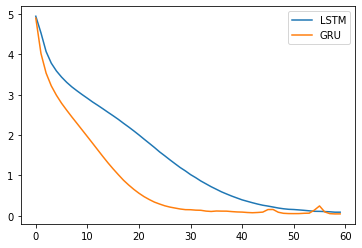

In [10]:
#学習推移の確認

%matplotlib inline
import matplotlib.pyplot as plt

loss_lstm = history_lstm.history['loss']
loss_gru = history_gru.history['loss']

plt.plot(np.arange(len(loss_lstm)), loss_lstm, label="LSTM")
plt.plot(np.arange(len(loss_gru)), loss_gru, label="GRU")
plt.legend()
plt.show()